# Predicting Taxi Orders for Sweet Lift Taxi

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import itertools
import statsmodels.api as sm

In [3]:
#importing the csv file
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#resampling the data to accumulate over 1 hour periods
taxi = taxi.resample('1H').sum()

In [4]:
taxi.info()
display(taxi.describe())
taxi.head(14)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [5]:
#finding number of times there are 0 
print(taxi['num_orders'].value_counts().loc[0])

1


***Take Aways:***
- No null values
- data is resampled for 1 hour periods
- min of 0 and max of 462

## Analysis

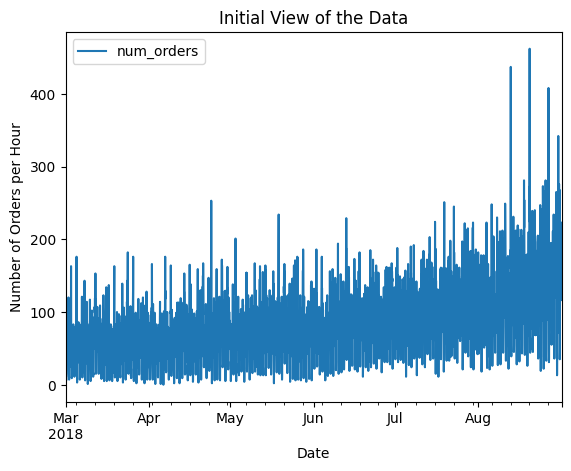

In [6]:
# Initial view of the data
taxi.plot()
plt.title("Initial View of the Data")  # Add title here
plt.xlabel('Date')
plt.ylabel('Number of Orders per Hour')
plt.show()

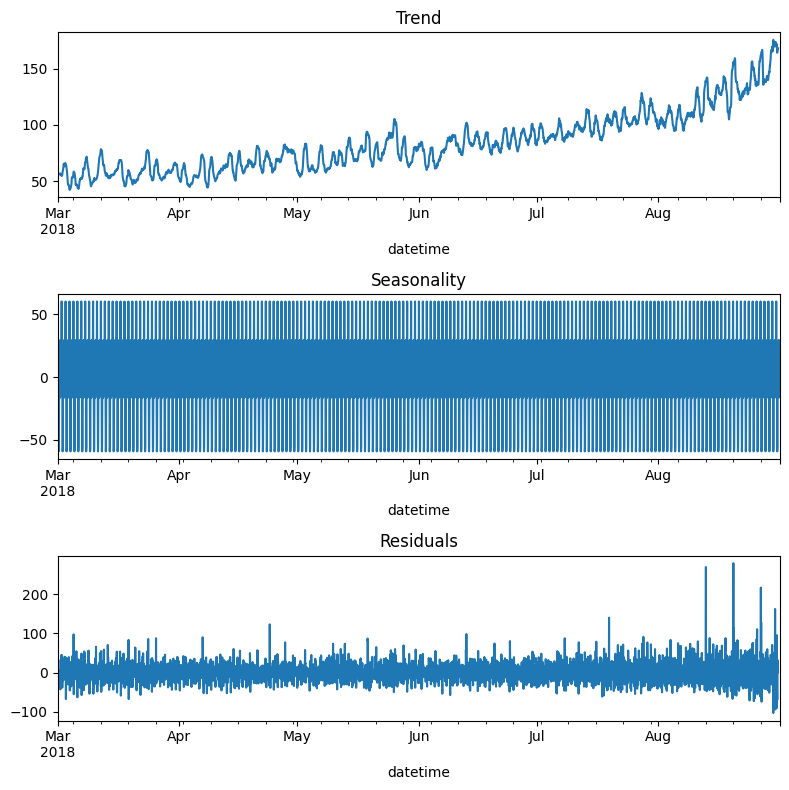

In [7]:
#plotting Trends and seasonality
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()   

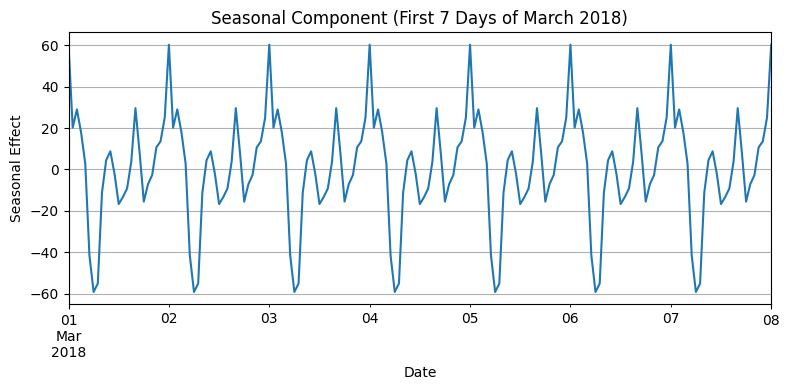

In [8]:
#PLotting the first 7 days of sesonality to see the data's cyclical pattern
plt.figure(figsize=(8, 4))  # Adjust figure size
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-08 00:00:00'].plot()  # Filter the seasonal component
plt.title('Seasonal Component (First 7 Days of March 2018)')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.grid(True)
plt.tight_layout()
plt.show()

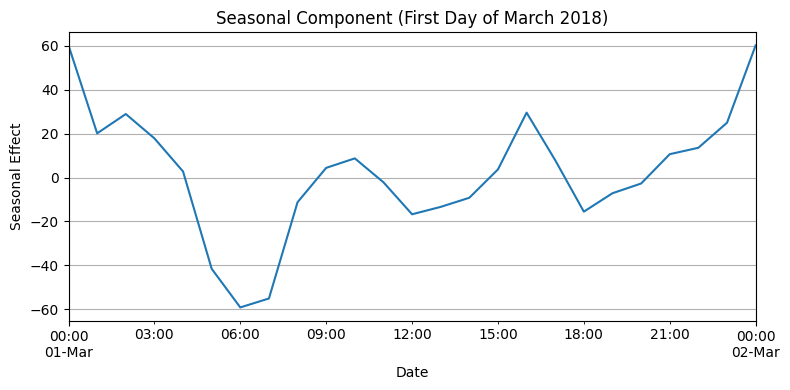

In [9]:
#Plotting one day of seaonality to see the daily repition
plt.figure(figsize=(8, 4))  # Adjust figure size
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot()  # Filter the seasonal component
plt.title('Seasonal Component (First Day of March 2018)')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.grid(True)
plt.tight_layout()
plt.show()

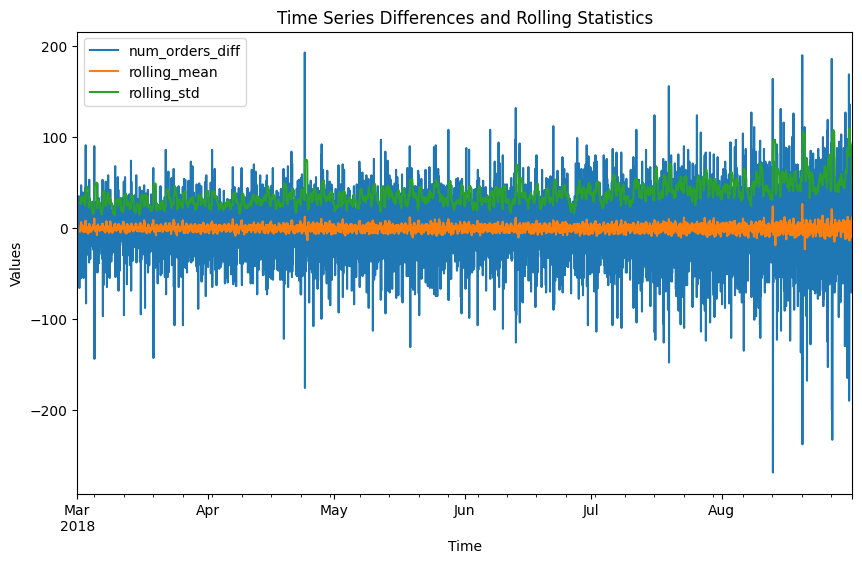

In [10]:
#Calculatint the time series differences
# Create a copy of the taxi DataFrame
taxi_2 = taxi.copy()

# Calculate the differences
taxi_2['num_orders_diff'] = taxi_2['num_orders'] - taxi_2['num_orders'].shift()

# Add rolling mean and standard deviation columns
taxi_2['rolling_mean'] = taxi_2['num_orders_diff'].rolling(15).mean()
taxi_2['rolling_std'] = taxi_2['num_orders_diff'].rolling(15).std()

# Plot the results
taxi_2[['num_orders_diff', 'rolling_mean', 'rolling_std']].plot(figsize=(10, 6), title="Time Series Differences and Rolling Statistics")
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

***Take Aways:***
- There is definite seasonality to the data that repeats on a daily basis
    - peaking at 0000 and having a low point at 0600.
- There is a slight upward trend


## Training

In [11]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

In [12]:
# run the adfuller test to check for stationarity
df_stationarityTest = adfuller(train, autolag='AIC')
print("P-value: ", df_stationarityTest[1])

P-value:  0.0007322730527364293


### Hyperparameter Tuning

In [13]:
# Use auto_arima to find the best ARIMA hyperparameters
auto_model = auto_arima(
    train, 
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=11.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39785.522, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39407.923, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39248.315, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39783.522, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.67 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=4.41 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=39246.314, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=1.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=39405.923, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.99 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 27.301 seconds
                               SARIMAX Results   

In [14]:
#additional check to see best parameters

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_params = None

for params in pdq:
    try:
        model = sm.tsa.ARIMA(train, order=params)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_params = params
    except:
        continue

print(f"Best parameters: {best_params}")


/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Best parameters: (2, 1, 2)


### Model Training

In [15]:
# MA Model
model_ma = ARIMA(train, order=(0, 0, 1))  # Moving Average
model_ma_fit = model_ma.fit()
print("MA Model Summary:")
print(model_ma_fit.summary())

# ARMA Model
model_arma = ARIMA(train, order=(2, 1, 2))  # ARMA Model
model_arma_fit = model_arma.fit()
print("ARMA Model Summary:")
print(model_arma_fit.summary())

# ARIMA Model with auto-selected hyperparameters
best_order = auto_model.order  # Extract the best order from auto_arima
model_arima = ARIMA(train, order=best_order)
model_arima_fit = model_arima.fit()
print("ARIMA Model Summary:")
print(model_arima_fit.summary())

MA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 3974
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -19650.994
Date:                Tue, 10 Dec 2024   AIC                          39307.988
Time:                        01:52:12   BIC                          39326.850
Sample:                    03-01-2018   HQIC                         39314.676
                         - 08-13-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.2958      0.857     91.387      0.000      76.617      79.975
ma.L1          0.4256      0.012     35.914      0.000       0.402       0.449
sigma2      1155.0009     19.733  

### Evaluating MA, ARMA, and ARIMA Models

MA Model RMSE: 84.73


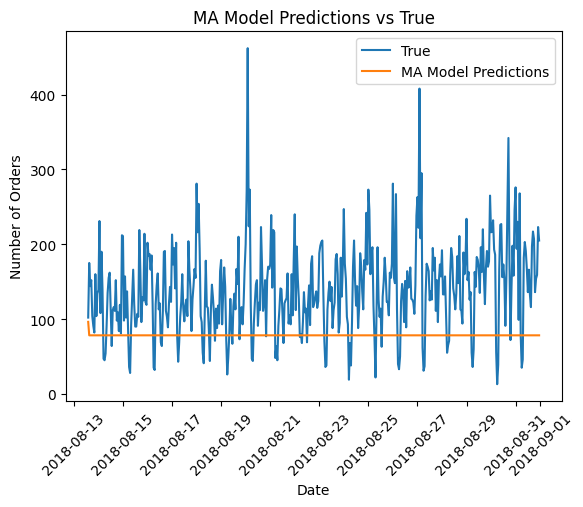

ARMA Model RMSE: 64.27


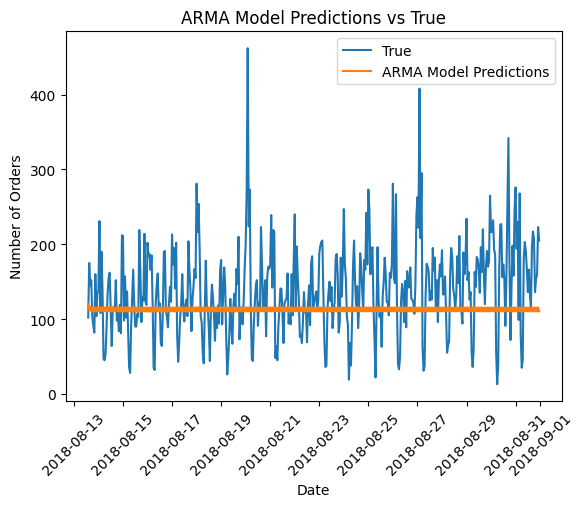

ARIMA Model RMSE: 62.77


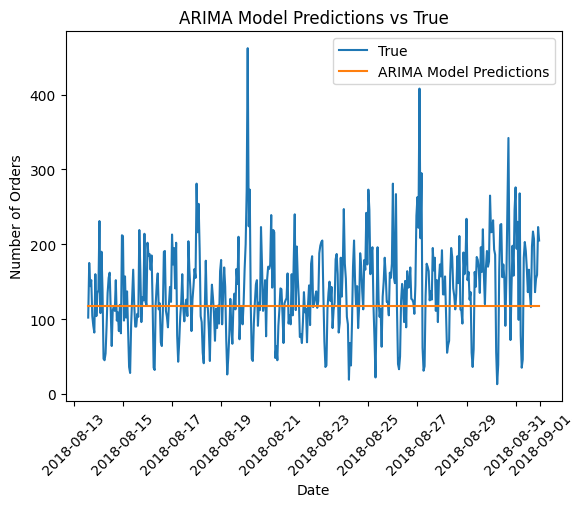

In [16]:
# Define a function to evaluate and plot predictions
def evaluate_model(model_fit, test_data, model_name):
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test_data) - 1)
    rmse = math.sqrt(mean_squared_error(test_data, predictions))
    print(f"{model_name} RMSE: {rmse:.2f}")
    plt.plot(test_data, label='True')
    plt.plot(predictions, label=f'{model_name} Predictions')
    plt.title(f"{model_name} Predictions vs True")
    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Evaluate MA, ARMA, and ARIMA models
evaluate_model(model_ma_fit, test, "MA Model")
evaluate_model(model_arma_fit, test, "ARMA Model")
evaluate_model(model_arima_fit, test, "ARIMA Model")

### SARIMA Models

In [17]:
# Train SARIMA model
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # Hourly seasonality
model_sarima_fit = model_sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65123D+00    |proj g|=  7.64820D-02


 This problem is unconstrained.



At iterate    5    f=  4.58621D+00    |proj g|=  3.57876D-02

At iterate   10    f=  4.49436D+00    |proj g|=  1.45487D-02

At iterate   15    f=  4.49187D+00    |proj g|=  1.07787D-03

At iterate   20    f=  4.48910D+00    |proj g|=  3.10354D-02

At iterate   25    f=  4.48790D+00    |proj g|=  2.05646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   6.302D-06   4.488D+00
  F =   4.4878982866933796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [18]:
# Train SARIMA model with tuning
model_sarima_tuned = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 24))  # Hourly seasonality
model_sarima_fit_tuned = model_sarima_tuned.fit()

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82882D+00    |proj g|=  4.80761D-01

At iterate    5    f=  4.58486D+00    |proj g|=  2.43331D-02

At iterate   10    f=  4.55648D+00    |proj g|=  2.90304D-02

At iterate   15    f=  4.49487D+00    |proj g|=  4.55934D-02

At iterate   20    f=  4.49201D+00    |proj g|=  5.11846D-03

At iterate   25    f=  4.48822D+00    |proj g|=  1.90451D-02

At iterate   30    f=  4.48780D+00    |proj g|=  1.15587D-03

At iterate   35    f=  4.48780D+00    |proj g|=  1.47936D-04

At iterate   40    f=  4.48778D+00    |proj g|=  2.93934D-03

At iterate   45    f=  4.48762D+00    |proj g|=  2.37802D-03

At iterate   50    f=  4.48736D+00    |proj g|=  6.58460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Train Exponential Smoothing model
model_exp = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=24)  # Hourly seasonality
model_exp_fit = model_exp.fit()

In [20]:
# Make predictions
pred_ma = model_ma_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred_arma = model_arma_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred_arima = model_arima_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred_sarima = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1)
pred_sarima_tuned = model_sarima_fit_tuned.predict(start=len(train), end=len(train)+len(test)-1)
pred_exp = model_exp_fit.predict(start=len(train), end=len(train)+len(test)-1)

### Feature Engineering for AR Model

In [21]:
# Feature Engineering for Train Data
train_features = train.copy()

# Extract time-based features
train_features['hour'] = train_features.index.hour
train_features['day_of_week'] = train_features.index.dayofweek
train_features['month'] = train_features.index.month

# Add lag features (past values of the target variable)
for lag in range(1, 4):  # Add lags for 1 to 3 previous time steps
    train_features[f'lag_{lag}'] = train['num_orders'].shift(lag)

# Drop rows with NaN values due to lagging
train_features = train_features.dropna()

# Separate target and features
y_train = train_features['num_orders']  # Target variable
X_train = train_features.drop(columns=['num_orders'])  # Features

### Train the Enhanced AR Model

In [22]:
# Fit an AR model with exogenous features
model_ar = SARIMAX(
    y_train, 
    exog=X_train,  # Pass the exogenous variables
    order=(3, 0, 0),  # AR(3) model
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_ar_fit = model_ar.fit()

# Print the model summary
print(model_ar_fit.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84096D+00    |proj g|=  3.51637D-02

At iterate    5    f=  4.83935D+00    |proj g|=  2.69287D-02

At iterate   10    f=  4.83867D+00    |proj g|=  4.11265D-03

At iterate   15    f=  4.83831D+00    |proj g|=  6.52292D-03

At iterate   20    f=  4.83567D+00    |proj g|=  4.55386D-02

At iterate   25    f=  4.83162D+00    |proj g|=  1.57726D-02

At iterate   30    f=  4.83054D+00    |proj g|=  6.51835D-02

At iterate   35    f=  4.82847D+00    |proj g|=  3.78267D-02

At iterate   40    f=  4.82332D+00    |proj g|=  8.44639D-02

At iterate   45    f=  4.82161D+00    |proj g|=  1.70455D-02


/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.82050D+00    |proj g|=  2.89931D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   2.899D-02   4.820D+00
  F =   4.8204990147783633     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 3971
Model:               SARIMAX(3, 0, 0)   Log Likelihood              -19142.202
Date:                Tue, 10 Dec 2024   AIC                          38304.403
Time:                        01:55:16   BIC  

### Feature Engineering for Test Data

In [23]:
# Feature engineering for Test Data
test_features = test.copy()
test_features['hour'] = test_features.index.hour
test_features['day_of_week'] = test_features.index.dayofweek
test_features['month'] = test_features.index.month

# Add lag features (past values of the target variable)
for lag in range(1, 4):
    test_features[f'lag_{lag}'] = test['num_orders'].shift(lag)

# Drop rows with NaN values due to lagging
test_features = test_features.dropna()

# Separate target and features
y_test = test_features['num_orders']  # Target variable
X_test = test_features.drop(columns=['num_orders'])  # Features

***Take Away:***
- Based on the adfuller test there is a high likelyhood that the data is stationary allowing for the use of the ARIMA models
- All six models have been trained and predictions were made
- As seen in the graphs of the ARIMA predictions, the predictions flatline and thus are not a good model for the data

## Testing / RMSE

In [24]:
def rmse(test,prediction, model):
    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(test, prediction)

    # Calculate the RMSE
    rmse = math.sqrt(mse)

    print(f"RMSE: {model}", rmse)

In [25]:
models = {
    "Moving Average": pred_ma,
    "ARMA": pred_arma,
    "ARIMA": pred_arima,
    "SARIMA": pred_sarima,
    "Tuned SARIMA": pred_sarima_tuned,
    "Exponential Smoothing": pred_exp,
}

# Loop through each model and its corresponding prediction
for model_name, prediction in models.items():
    rmse(test, prediction, model_name)

RMSE: Moving Average 84.7333659242237
RMSE: ARMA 64.27024912019279
RMSE: ARIMA 62.76809456268275
RMSE: SARIMA 44.4600827121111
RMSE: Tuned SARIMA 44.155689802056536
RMSE: Exponential Smoothing 40.39903153177998


## Conclusion

- Over the 6 different model testing, half of them achieve the 48 or better RMSE value
- The best model was Exponential Smoothing followed by the SARIMA models